# Insight Generation

*This notebook represents the whole data pipeline* ***text input -> Insight***. 

In [33]:
INPUT = "EVERY substance is negatively electric to that which stands above \
in the chemical tables, positively to that which stands below \
it. Water dissolves wood and iron and salt; air dissolves water;\
electric fire dissolves air, but the intellect dissolves fire, gravity,\
laws, method, and the subtlest unnamed relations of nature in its \
resistless menstruum. Intellect lies behind genius, which is intellect constructive. Intellect is the simple power anterior to all \
action or construction. Gladly would I unfold in calm degrees a \
natural history of the intellect, but what man has yet been able \
to mark the steps and boundaries of that transparent essence? \
The first questions are always to be asked, and the wisest doctor \
is gravelled by the inquisitiveness of a child. How can we speak \
of the action of the mind under any divisions, as of its knowledge, \
of its ethics, of its works, and so forth, since it melts will into \
perception, knowledge into act? Each becomes the other. Itself \
alone is. Its vision is not like the vision of the eye, but is union \
with the things known.\
Intellect and intellection signify to the common ear consideration of abstract truth. The consideration of time and place, of \
you and me, of profit and hurt, tyrannize over most men's minds.\
Intellect separates the fact considered, from you, from all local\
and personal reference, and discerns it as if it existed for its own \
sake. Heraclitus looked upon the affections as dense and colored \
mists. In the fog of good and evil affections it is hard for man to \
walk forward in a straight line .. Intellect is void of affection and \
sees an object as it stands in the light of science, cool and disengaged. The intellect goes out of the individual, floats over its own \
personality, and regards it as a fact, and not as I and mine. He, \
who is immersed in what concerns person or place cannot see the \
problem of existence. This the intellect always ponders. Nature \
shows all things formed and bound. The intellect pierces the \
form, overleaps the wall, detects intrinsic likeness between remote things and reduces all things into a few principles."
INPUT

"EVERY substance is negatively electric to that which stands above in the chemical tables, positively to that which stands below it. Water dissolves wood and iron and salt; air dissolves water;electric fire dissolves air, but the intellect dissolves fire, gravity,laws, method, and the subtlest unnamed relations of nature in its resistless menstruum. Intellect lies behind genius, which is intellect constructive. Intellect is the simple power anterior to all action or construction. Gladly would I unfold in calm degrees a natural history of the intellect, but what man has yet been able to mark the steps and boundaries of that transparent essence? The first questions are always to be asked, and the wisest doctor is gravelled by the inquisitiveness of a child. How can we speak of the action of the mind under any divisions, as of its knowledge, of its ethics, of its works, and so forth, since it melts will into perception, knowledge into act? Each becomes the other. Itself alone is. Its visi

## Settings and Dependencies

In [34]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='*****************', project_access_token='*****************')
pc = project.project_context


In [35]:
# base libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json

## Stage I - Personality Insight Transformation

In [36]:
!pip install ibm_watson

In [37]:
from ibm_watson import PersonalityInsightsV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

### Autorization in Personality Insight

In [38]:
url = "https://gateway-fra.watsonplatform.net/personality-insights/api"
apikey = "*****************"

# # Authentication via IAM
authenticator = IAMAuthenticator(apikey)
service = PersonalityInsightsV3(
    version='2017-10-13',
    authenticator=authenticator)
service.set_service_url(url)

### Generating Personality Profile of the input

In [39]:
def generate_profile_df(profile, element):
        
    ex_dict = {el['name']:el['percentile'] for el in profile[element]}
    
    return pd.DataFrame.from_records(ex_dict, index=[0], columns=ex_dict.keys())

def text2profile(text, profile_elements = ['personality', 'needs', 'values']):
    try:
        profile = service.profile(
            text,
            'application/json',
            raw_scores=True,
            consumption_preferences=False).get_result()

        result = pd.DataFrame()
        for el in profile_elements:
            result = pd.concat([result, generate_profile_df(profile, el)], axis = 1)
        
        return result.iloc[0]
    except Exception:
        pass

In [40]:
profile = text2profile(INPUT)

In [41]:
profile = pd.DataFrame(profile)
profile = profile.T
profile

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,Harmony,...,Love,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence
0,0.999999,0.338662,0.346933,0.003487,0.50481,0.016307,0.015079,0.999189,0.082939,0.075291,...,0.089779,0.198824,0.408336,0.037666,0.096991,0.002983,0.836938,0.024841,0.090436,0.373138


---

---

## Autorization in Watson ML

In [42]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

# Credentials from Watson Machine Learning service
wml_credentials = {
  "apikey": "*****************",
  "iam_apikey_description": "*****************",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "*****************",
  "instance_id": "*****************",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [43]:
client = WatsonMachineLearningAPIClient(wml_credentials)
instance_details = client.service_instance.get_details()

In [44]:
client.deployments.list()

------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME               TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
726d0f57-6b51-404d-959f-de7a115afc6f  Kmeans clustering  online  DEPLOY_SUCCESS  2020-07-20T17:25:24.188Z  scikit-learn-0.20  model
2390ef45-fbbb-44a5-b06e-026b107606e2  Encoder_v1         online  DEPLOY_SUCCESS  2020-07-20T17:24:23.383Z  tensorflow-1.15    model
------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------


In [45]:
base_link = "https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/"
scoring_endpoint_encoder = base_link + "2390ef45-fbbb-44a5-b06e-026b107606e2" + "/online"
scoring_endpoint_kmeans = base_link + "726d0f57-6b51-404d-959f-de7a115afc6f" + "/online"

In [46]:
print("Encoder: ", scoring_endpoint_encoder)
print("Kmeans: ", scoring_endpoint_kmeans)

Encoder:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/2390ef45-fbbb-44a5-b06e-026b107606e2/online
Kmeans:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/726d0f57-6b51-404d-959f-de7a115afc6f/online


---

---

## Stage II - Dimensionality reduction - Extraction of factors

In [47]:
X = profile.to_numpy()
X = np.round(X, 3)
X = X[0].tolist()
X

[1.0,
 0.339,
 0.347,
 0.003,
 0.505,
 0.016,
 0.015,
 0.999,
 0.083,
 0.075,
 0.157,
 0.171,
 0.09,
 0.199,
 0.408,
 0.038,
 0.097,
 0.003,
 0.837,
 0.025,
 0.09,
 0.373]

In [48]:
encoder_scoring_payload = {'values': [X]}
encoder_prediction = client.deployments.score(scoring_endpoint_encoder, encoder_scoring_payload)

In [49]:
found_factors = encoder_prediction['values'][0]
found_factors = [round(f, 5) for f in found_factors]
found_factors

[0.00453, 0.00172]

## Stage III - Personality classification of the instance

In [50]:
kmeans_scoring_payload = {'values': [found_factors]}
kmeans_prediction = client.deployments.score(scoring_endpoint_kmeans, kmeans_scoring_payload)

In [51]:
Y_pred = kmeans_prediction['values'][0][0]
Y_pred

0

## Auxiliary functions

In [52]:
def Davies_Bouldin_index(df, cats, cluster_cores, distance=np.linalg.norm, order=1):
    
    n = len(cluster_cores)
    sigmas = np.zeros(n)
    
    # average intra-cluster distances
    for i, cc in enumerate(cluster_cores):
        sigmas[i] = np.mean(df[df[cats] == i].apply(lambda row: distance(row[:-1] - cluster_cores[i], ord=order), axis=1))
    
    # max intra-inter relations
    dists = [np.max([(sigmas[i] + sigmas[j])/distance(cluster_cores[i], cluster_cores[j], order) for j in range(n) if i != j]) for i in range(n)]
    return np.mean(dists)
    
    
def Distribution_distance(x, mean, cov):
    n = len(mean)
    stds = np.array([[cov[i, j] for j in range(n) if i == j][0] for i in range(n)])
    
    return scipy.linalg.norm(np.divide(np.abs(x-mean), stds))

def Mahalanobis_distance(x, mean, inv_cov):
    return (x-mean).T@inv_cov@(x-mean)

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def minmax_scaling(z):
    return (z - np.min(z))/(np.max(z) - np.min(z))

def Davies_Bouldin_Mahalanobis(df, cats, cluster_cores, inv_cov):
    
    n = len(cluster_cores)
    sigmas = np.zeros(n)
    if len(inv_cov.shape) == 2:
        ic = inv_cov.copy()
        inv_cov = np.zeros((n, ic.shape[0], ic.shape[1]))
        for i in range(n):
            inv_cov[i] = ic.copy()
            
    # average intra-cluster distances
    for i, cc in enumerate(cluster_cores):
        sigmas[i] = np.mean(df[df[cats] == i].apply(lambda row: Mahalanobis_distance(row[:-1], cc, inv_cov[i]), axis=1))
    
    # max intra-inter relations
    dists = [np.max([(sigmas[i] + sigmas[j])/Mahalanobis_distance(cluster_cores[i], cluster_cores[j], inv_cov[j]) for j in range(n) if i != j]) for i in range(n)]
    return np.mean(dists)

def boxplot(param, cats, data, ax=None):
    if not ax:
        fig, (ax) = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle('A box plot', fontsize=14)

    sns.boxplot(x=cats, y=param, data=data,  ax=ax, orient='v')
    ax.set_xlabel("{:s}".format(param),size = 12,alpha=0.8)
    ax.set_ylabel(param,size = 12,alpha=0.8)
    
def radar_plot(data, traits, COLOR='coral', 
               title=None, ax=None, labeled=None, 
               drop_xticks=False, drop_yticks=False, alpha0=1.0):
    N = len(traits)
    # arclength from 0 up to this point (i)
    angles = [2*np.pi*i/N for i in range(N)]
    
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(111, polar=True)

    # structure
    ax.set_xticks(angles)
    plt.xticks(angles, traits)
    ax.set_yticks([0, 0.2, 0.5, 0.8, 1.0])
    ax.set_thetalim(0, 2*np.pi)
    ax.tick_params(direction='out', labelsize=12, colors='black',
               grid_color='dimgrey', grid_alpha=0.8, labelrotation='auto')
    
    if drop_xticks:
        plt.tick_params(
                axis='both',    
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
    
    if drop_yticks:
        ax.set_yticks([])

    # duplicating first point to close the circle
    data = np.append(data, data[0])
    angles.append(angles[0])
    
    if title:
        ax.set_title(title, fontsize=16)
    
    ax.plot(angles, data, color=COLOR, linewidth=3, label=labeled)
    ax.plot(angles, data, color=COLOR, linewidth=5, alpha=alpha0*0.1)
    ax.plot(angles, data, color=COLOR, linewidth=8, alpha=alpha0*0.5)
    ax.fill(angles, data, alpha=alpha0*0.23, color=COLOR);
    
    
def silhouette_evaluation(df, plot=True, distance='l2',samples_per_class=50, cmap='hsv', verbose=True):
    
    X = df.to_numpy()
    labels = X[:, -1]
    X = X[:, :-1]
    cluster_codes, cluster_lengths = np.unique(labels, return_counts=True)
    
    sil = silhouette_samples(X, labels, metric=distance)
    sil_score = silhouette_score(X, labels, metric=distance)
    
    res_df = pd.DataFrame(np.stack([labels, sil], axis=1), columns=['Class', 'Silhouette'])
    sil_means = res_df.groupby('Class').mean()
    
    if verbose:
        print('Silhouette quality of each cluster:')
        print(sil_means)
        print('Silhouette score of the clustering is: ', sil_score)
    if plot:
        sample_df = pd.DataFrame(columns=['Class', 'Silhouette'])
        ax_labels = []
        
        for cat in cluster_codes:
            sample_df = pd.concat([sample_df, res_df[res_df['Class'] == cat].sample(samples_per_class)])
            ax_labels.append("Cluster {:d}".format(int(cat)))
            
        # Create a color palette:
        my_palette = plt.cm.get_cmap(cmap, len(cluster_codes))
        sam = sample_df.to_numpy()
        sam_class = sam[:, 0]
        sam_sil = sam[:, 1]
        
        fig, ax = plt.subplots(figsize=(15, 20))
        plt.title('Silhouette values', fontsize=20)
        
        plt.barh(y=np.arange(0, len(sam_sil)), width=sam_sil, edgecolor='k',
                 color=my_palette(sam_class/np.max(sam_class)))
        
        ax.set_yticks(cluster_codes*samples_per_class + samples_per_class//2)
        ax.set_yticklabels(ax_labels, fontsize=13, rotation='vertical')
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Silhouette', fontsize=15)              
        
        
    return res_df, sil_means, sil_score

def Lk_norm(point1, point2, k=2):
    
    n = len(point1)
    return np.power(np.sum([np.abs(point1[i] - point2[i])**k for i in range(n)]), 1/k)

## Loading datasets

In [53]:
f = project.get_file('clustered_2d.csv')
df_2d = pd.read_csv(f)
df_2d.head()

,F_0,F_1,Class
0,0.409489,0.338681,1
1,0.885318,0.866873,3
2,0.880722,0.861420,3
3,0.455465,0.387308,1
4,0.398444,0.327139,1


In [54]:
f = project.get_file('clustered_22d.csv')
df_22d = pd.read_csv(f)
df_22d.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,Harmony,...,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence,Class
0,0.672358,0.515518,0.202560,0.388493,0.952090,0.449133,0.491036,0.373575,0.361041,0.673358,...,0.527576,0.765530,0.314229,0.463151,0.362166,0.480516,0.437073,0.592248,0.485292,1
1,0.769577,0.442860,0.063138,0.152624,0.998766,0.792551,0.712586,0.726484,0.940915,0.769730,...,0.991403,0.998430,0.923608,0.908561,0.743416,0.608181,0.473193,0.882402,0.857386,3
2,0.445128,0.776801,0.899640,0.881138,0.706536,0.857511,0.842577,0.751038,0.759625,0.892253,...,0.529881,0.791273,0.899268,0.607543,0.917088,0.715703,0.825515,0.962015,0.753915,3
3,0.707812,0.725007,0.057476,0.296220,0.990815,0.551724,0.447475,0.519926,0.487398,0.721506,...,0.546406,0.840359,0.770971,0.740211,0.411759,0.566608,0.215377,0.478906,0.604419,1
4,0.659059,0.788241,0.708605,0.238162,0.566861,0.686579,0.331890,0.248036,0.528839,0.559211,...,0.619599,0.413212,0.747458,0.800460,0.741150,0.436434,0.685875,0.959131,0.235388,1


In [55]:
cores_2d = df_2d.groupby('Class').mean()
cores_2d

,F_0,F_1
Class,,
0,0.040679,0.024173
1,0.481850,0.415288
2,0.287010,0.218011
3,0.841671,0.815812


In [56]:
cores = df_22d.groupby('Class').mean()
cores

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,Harmony,...,Love,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence
Class,,,,,,,,,,,,,,,,,,,,,
0,0.828304,0.671916,0.427579,0.364012,0.426822,0.235927,0.184035,0.393397,0.134932,0.215709,...,0.157807,0.249758,0.220868,0.329749,0.486794,0.186616,0.314203,0.143448,0.205653,0.170221
1,0.584826,0.632870,0.335157,0.521356,0.610588,0.665635,0.525092,0.654969,0.462274,0.669602,...,0.467813,0.518862,0.575237,0.691474,0.677331,0.552233,0.580142,0.442503,0.609028,0.464238
2,0.687288,0.661141,0.340288,0.444678,0.545241,0.513015,0.347198,0.542806,0.277933,0.459801,...,0.300428,0.387970,0.384110,0.520509,0.625822,0.368131,0.448770,0.263303,0.425241,0.317195
3,0.452814,0.508488,0.311792,0.548821,0.685601,0.772411,0.738512,0.796520,0.759624,0.825053,...,0.694132,0.725447,0.815812,0.817366,0.713513,0.742562,0.767829,0.755216,0.822490,0.662989


## Stage IV - Results

***This section presents the insight gained from the input text data. It allows to:***

* ***Analyze the predicted class;***
* ***Inspect and compare various radar plots of the profile, the core of its cluster and other clusters;***
* ***Examine the factors in lower dimension and the position of the instance in the corresponding domain.***

***Based on this information, it is possible to come up with a personalized and, hopefully, more efficient approach to this person in a matter of communication.***

In [57]:
if Y_pred == 0:
    print("Given instance is predicted to belong to class 0. It is a very good class.")
elif Y_pred == 1:
    print("Given instance is predicted to belong to first class. It is also a good class.")
elif Y_pred == 2:
    print("Given instance is predicted to belong to second class. This one is great.")
elif Y_pred == 3:
    print("Given instance is predicted to belong to third class. Fascinating result.")

Given instance is predicted to belong to class 0. It is a very good class.


In [58]:
big5_keys = list(df_22d.iloc[:3, 0:5].columns)
needs_keys_1 = list(df_22d.iloc[:3, 5:12].columns)
needs_keys_2 = list(df_22d.iloc[:3, 12:18].columns)
values_keys = list(df_22d.iloc[:3, 18:-1].columns)
trait_columns = {'Needs 1': needs_keys_1, 'Needs 2': needs_keys_2, 'Big5': big5_keys, 'Values': values_keys}
hex_traits = big5_keys.copy()
hex_traits.append('Self-transcendence')

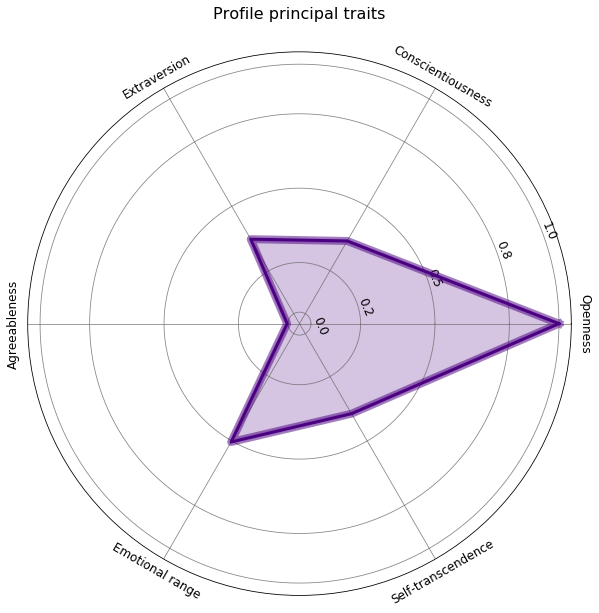

In [59]:
radar_plot(data = profile[hex_traits].to_numpy()[0], traits=hex_traits, 
           COLOR='indigo', drop_yticks=False, drop_xticks=False, title='Profile principal traits')

In [60]:
# Creating a color palette:
my_palette = plt.cm.get_cmap("Accent", len(cores.index))
RGB_codes = np.array([my_palette(0), my_palette(1), my_palette(2), my_palette(3)])
RGB_codes = RGB_codes[:, :-1]

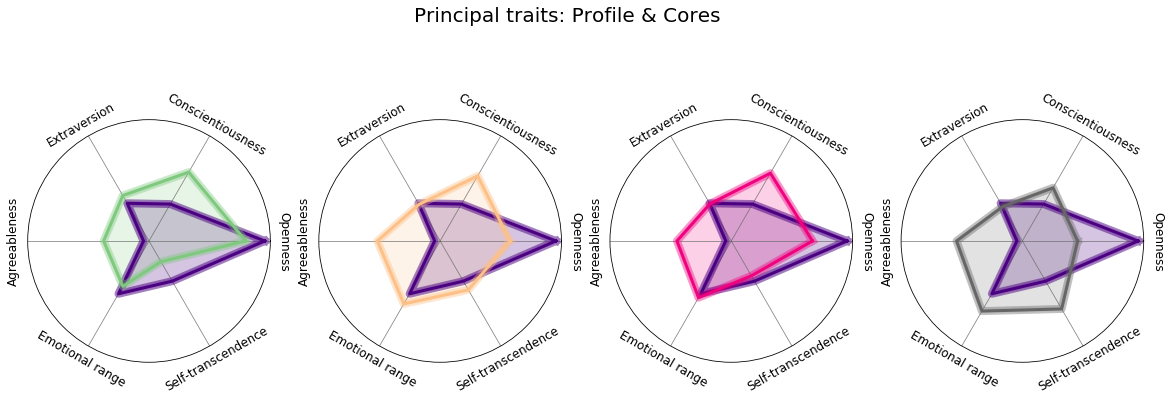

In [61]:
nb_clusters = len(cores)

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Principal traits: Profile & Cores', fontsize=20)

for i in range(nb_clusters):
    axs = plt.subplot(2, nb_clusters, i+1, polar=True)
    # axs.set_title('Cluster {:d}'.format(i), fontsize=14)
    radar_plot(data = profile[hex_traits].to_numpy()[0], traits=hex_traits, 
           COLOR='indigo', ax=axs, drop_yticks=True, drop_xticks=False)
    
    radar_plot(data = cores[hex_traits].to_numpy()[i], traits=hex_traits, 
               COLOR=my_palette(i), ax=axs, drop_yticks=True, drop_xticks=False, alpha0=0.8)
    

    

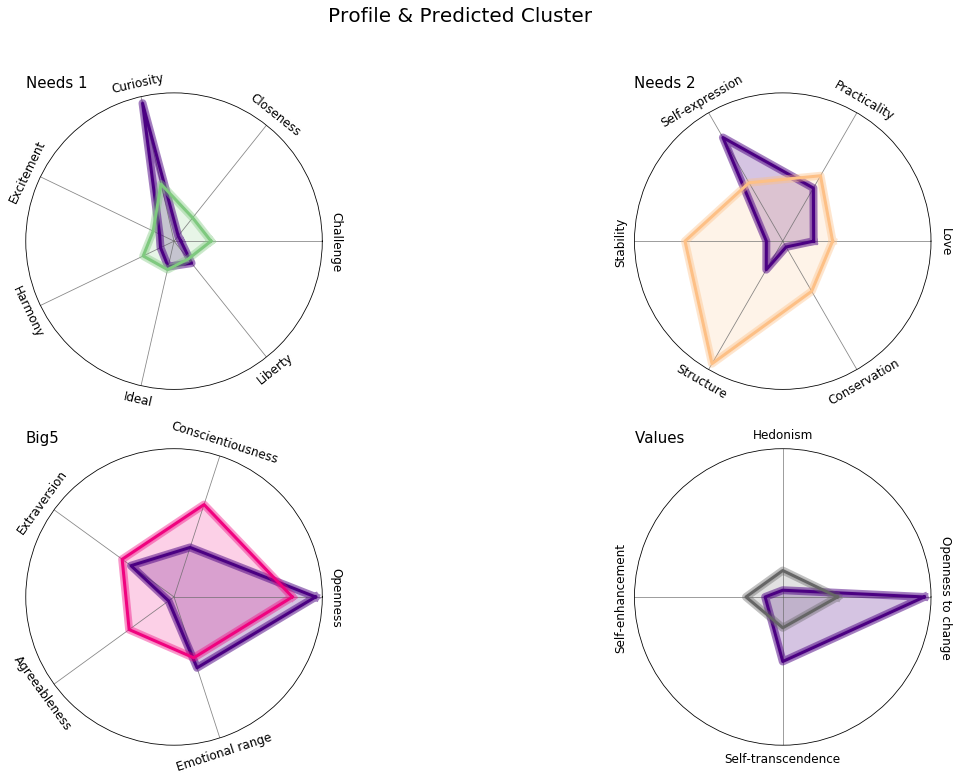

In [62]:
# Create a color palette:
my_palette = plt.cm.get_cmap("Accent", len(cores.index))

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Profile & Predicted Cluster', fontsize=20)
predicted_cluster = cores.loc[Y_pred]

for i, t in enumerate(trait_columns):

    axs = plt.subplot(2, 2, i+1, polar=True)
    
    axs.set_title(t, fontsize=15, loc='left')
    radar_plot(data = profile[trait_columns[t]].to_numpy()[0], traits=trait_columns[t], 
           COLOR='indigo', ax=axs, drop_yticks=True, drop_xticks=False)
    
    radar_plot(data = predicted_cluster[trait_columns[t]].to_numpy(), traits=trait_columns[t], 
               COLOR=my_palette(i), ax=axs, drop_yticks=True, drop_xticks=False, alpha0=0.8)
    

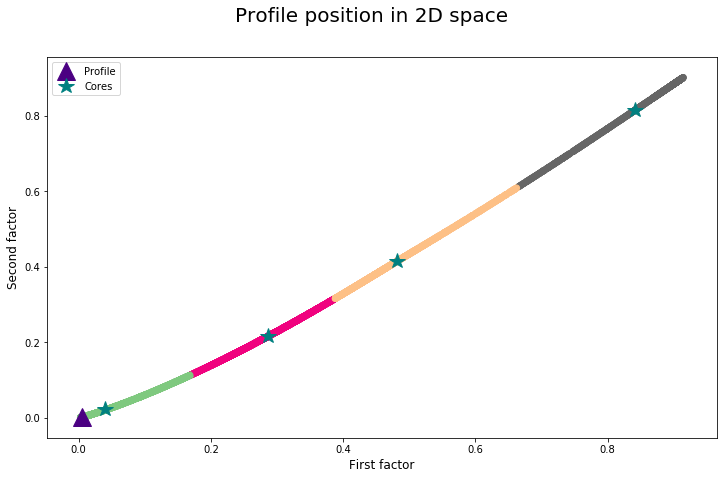

In [63]:
data_2d = df_2d.to_numpy()

fig = plt.figure(figsize=(12, 7))
fig.suptitle('Profile position in 2D space', fontsize=20)
plt.xlabel('First factor', fontsize=12)
plt.ylabel('Second factor', fontsize=12)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=data_2d[:, 2], cmap=my_palette)
plt.plot(found_factors[0], found_factors[1], '^', color='indigo', markersize=18, label='Profile');
plt.plot(cores_2d.to_numpy()[:, 0], cores_2d.to_numpy()[:, 1], '*', color='teal', markersize=16, label='Cores');
plt.legend();

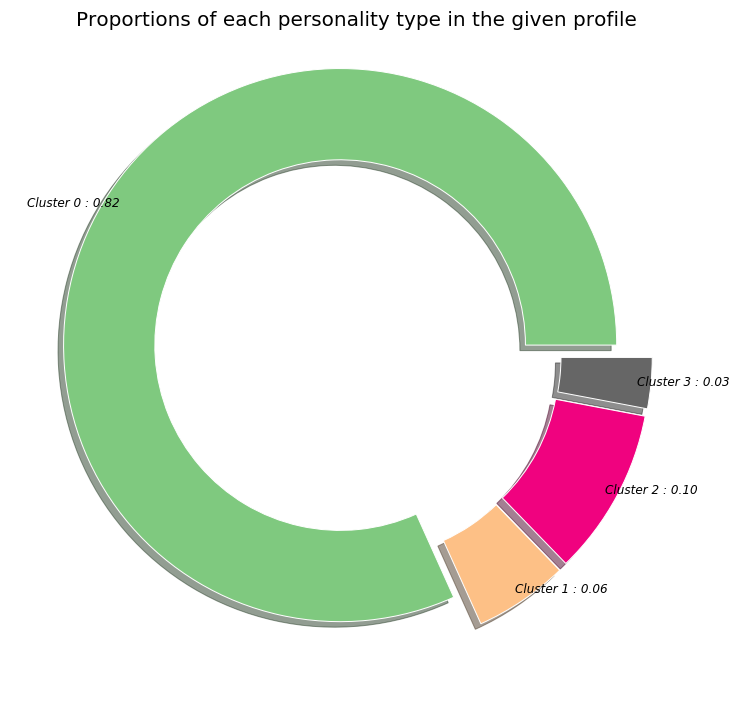

In [64]:
distances = np.array([np.linalg.norm(found_factors - core) for core in cores_2d.to_numpy()])
proportions = 1/distances
proportions /= np.sum(proportions)
explosions = np.ones_like(proportions)*0.07
labels = ["Cluster {:d} : {:.2f}".format(i, proportions[i]) for i in range(nb_clusters)]

fig = plt.figure(figsize=(12, 10))
fig.suptitle('Proportions of each personality type in the given profile', fontsize=20)

plt.pie(proportions, explode=explosions, colors=RGB_codes, labels=labels, 
        shadow=True, labeldistance=0.95, 
        wedgeprops = {"edgecolor":'w', "width":0.33},
        textprops={"fontsize":12, "fontstyle":"oblique", "sketch_params":(4, 120, 20)});

plt.tight_layout()
plt.show()

**The end.**